In [19]:
#library imports
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split

import pickle

#switch to cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Normal points: 1093
Total anomalies: 137
Predicted anomalous seconds and their counts:
Second: 0 Count: 2
Second: 1 Count: 1
Second: 2 Count: 1
Second: 3 Count: 1
Second: 8 Count: 1
Second: 9 Count: 1
Second: 10 Count: 1
Second: 16 Count: 1
Second: 17 Count: 1
Second: 18 Count: 1
Second: 24 Count: 1
Second: 25 Count: 1
Second: 26 Count: 1
Second: 28 Count: 2
Second: 31 Count: 1
Second: 32 Count: 1
Second: 33 Count: 2
Second: 34 Count: 1
Second: 61 Count: 2
Second: 63 Count: 2
Second: 64 Count: 2
Second: 65 Count: 2
Second: 66 Count: 2
Second: 67 Count: 2
Second: 69 Count: 2
Second: 70 Count: 2
Second: 71 Count: 2
Second: 72 Count: 2
Second: 74 Count: 2
Second: 75 Count: 2
Second: 76 Count: 2
Second: 77 Count: 2
Second: 78 Count: 2
Second: 79 Count: 2
Second: 80 Count: 2
Second: 82 Count: 2
Second: 84 Count: 2
Second: 85 Count: 2
Second: 86 Count: 2
Second: 87 Count: 2
Second: 88 Count: 2
Second: 89 Count: 2
Second: 90 Count: 2
Second: 91 Count: 2
Second: 92 Count: 2
Second: 95 Count: 2

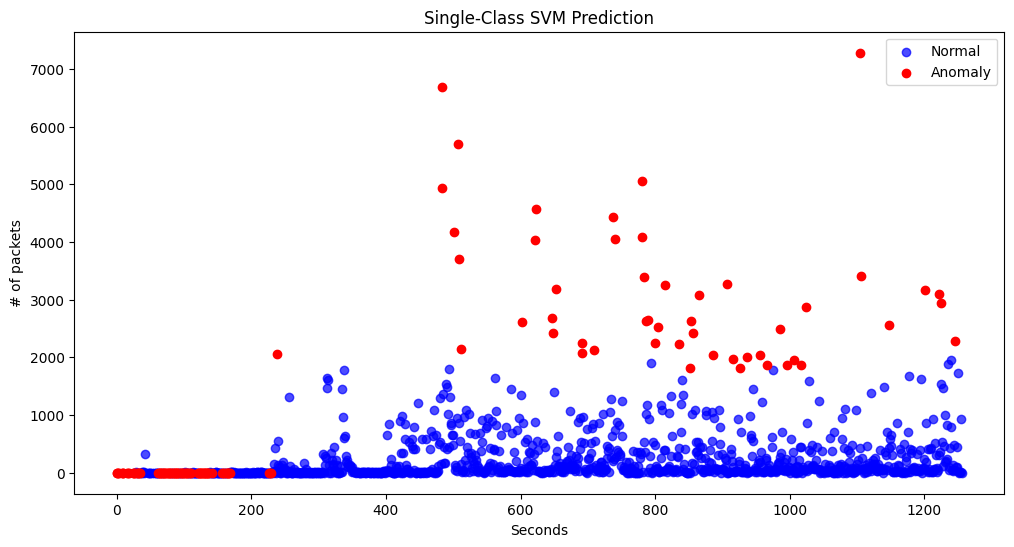

In [ ]:
class AnomalyDetection:
    def __init__(self):
        #initialize global variables
        self.file = None
        self.model = None
        self.x_train = None
        self.x_val = None
        self.x_test = None
        self.input = None
        self.training_results = None


    def user_input(self):
        self.input = int(input("0 for training | 1 for test:"))


    #read file
    def read_csv(self):
        if(self.input == 0):
            file_path = "data/training.csv"
        elif(self.input == 1):
            file_path = "data/test.csv"
        self.file = pd.read_csv(file_path)
        

    def aggregate_data(self):
        #grouping by amount in each second
        self.file["Count"] = self.file.groupby(by="Second").transform("size")

        #remove duplicate seconds
        self.file = self.file.drop_duplicates(subset="Second")

        #rolling anomaly detection
        window_size = 10
        self.file["WindowCount"] = self.file["Count"].rolling(window=window_size, min_periods=1).mean()


    def data_clean(self):
        #drop unused columns 
        self.file = self.file.drop(columns=["Source","No.","Destination","Protocol","Length","Info"])

        #parse Time header into second and any smaller unit of time
        self.file["Time"] = self.file["Time"].astype(str) 
        self.file[["Second", "Smaller"]] = self.file["Time"].str.split(".", expand=True) 
        self.file = self.file.drop(columns="Time")
        self.file["Second"] = self.file["Second"].astype(int)

        #create a Count and WindowCount column
        self.aggregate_data()

        #split into train and validate only on training data.
        if(self.input == 0):
            self.x_train = self.file[["Count", "WindowCount"]]
            self.x_train, self.x_val = train_test_split(self.x_train, test_size=0.2, random_state=42)

        if(self.input == 1):
            self.x_test = self.file[["Count", "WindowCount"]]


    #define single-class SVM model
    def model_definition(self):
        self.model = svm.OneClassSVM(kernel="rbf", nu=0.08)

        #if training dataset: train & save model
        if(self.input == 0): 
            self.model.fit(self.x_train)
            pickle.dump(self.model, open("trained_model.pkl", "wb")) #write mode

        self.trained_model = pickle.load(open("trained_model.pkl", "rb")) #read mode
            

    #training
    def prepare_model(self):
        self.read_csv()
        self.data_clean()
        self.model_definition()


    def print_results(self, set_normal, set_anomalies):
        #print amount of points and predicted anomalous seconds
        print(f"Normal points: {len(set_normal)}")
        print(f"Total anomalies: {len(set_anomalies)}")
        print(f"Predicted anomalous seconds and their counts:")

        #get seconds for each row in normal and anomalous set
        set_normal = set_normal.copy() #preserve original sets (gives warning if not)
        set_anomalies =set_anomalies.copy()

        set_normal["Second"] = self.file.loc[set_normal.index, "Second"]
        set_anomalies["Second"] = self.file.loc[set_anomalies.index, "Second"]

        set_anomalies = set_anomalies.sort_values(by="Second") #sort for readability
        for i in range(len(set_anomalies)):
            print(f"Second: {set_anomalies["Second"].iloc[i]} Count: {set_anomalies["Count"].iloc[i]}")
        
        #plot prediction
        plt.figure(figsize=(12,6))
        plt.title("Single-Class SVM Prediction")
        plt.xlabel("Seconds")
        plt.ylabel("# of packets")

        plt.scatter(set_normal["Second"], set_normal["Count"], label="Normal", color="blue", alpha=0.7)
        plt.scatter(set_anomalies["Second"], set_anomalies["Count"], label="Anomaly", color="red")

        plt.legend()
        plt.show()


    #prediction
    def model_prediction(self):
        self.user_input()
        self.prepare_model() 
        
        if self.input == 0:
            #prediction
            train_prediction = self.model.predict(self.x_train)
            val_prediction = self.trained_model.predict(self.x_val)

            #separate normal and anomalous points
            train_normal = self.x_train[train_prediction == 1]
            train_anomalies = self.x_train[train_prediction == -1]

            val_normal = self.x_val[val_prediction == 1]  
            val_anomalies = self.x_val[val_prediction == -1] 

            self.print_results(train_normal, train_anomalies)
            self.print_results(val_normal, val_anomalies)
           

        if self.input == 1:
            test_prediction = self.trained_model.predict(self.x_test)

            test_normal = self.x_test[test_prediction == 1]
            test_anomalies = self.x_test[test_prediction == -1]

            self.print_results(test_normal, test_anomalies)


detection = AnomalyDetection()
detection.model_prediction()